In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# this code is for working in colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# path to  CSV file in  Drive
csv_path = '/content/drive/MyDrive/retailrocket/filtered_sessions.csv'


In [ ]:
data = pd.read_csv(csv_path)


In [ ]:
data.head()

,timestamp,visitorid,event,itemid,category,global_session_id,interaction_type_id,time_since_last_interaction_logscaled,item_preference_logscaled,item_popularity_logscaled,time_since_session_start_logscaled,session_duration_logscaled
0,2015-09-11 20:49:49.439,0,view,285930,1188,0:START:20150911204949:DUR:00327s,3,0.189860,0.080446,0.229065,0.289316,0.468937
1,2015-09-11 20:52:39.591,0,view,357564,256,0:START:20150911204949:DUR:00327s,3,0.000000,0.000000,0.883486,0.000000,0.000000
2,2015-09-11 20:55:17.175,0,view,67045,333,0:START:20150911204949:DUR:00327s,3,0.000000,0.000000,0.738648,0.000000,0.000000
3,2015-08-07 17:51:44.567,2,view,325215,299,2:START:20150807175144:DUR:01753s,3,0.244409,0.298417,0.684853,0.657039,0.677851
4,2015-08-07 17:53:33.790,2,view,325215,299,2:START:20150807175144:DUR:01753s,3,0.000000,0.000000,0.287558,0.000000,0.000000


In [ ]:


# Sort Data
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.sort_values(by=['visitorid', 'timestamp'], inplace=True)

# Encode the user IDs and interaction types as integers
user_encoder = LabelEncoder()
data['user_id_encoded'] = user_encoder.fit_transform(data['visitorid'])


# Encode 'interaction_type_id'
interaction_types = data['interaction_type_id'].unique().tolist()
interaction_encoder = LabelEncoder()
interaction_encoder.fit(interaction_types)

# transform data with this updated encoder
data['interaction_type_encoded'] = interaction_encoder.transform(data['interaction_type_id'])

In [ ]:
data.sort_values(by=['visitorid', 'timestamp'], inplace=True)


In [ ]:
#set cutoff points
train_cutoff = data['timestamp'].quantile(0.70)
val_test_cutoff = data['timestamp'].quantile(0.85)

# Assign sessions to train, validation, or test set based on the cutoff dates
train_sessions = data[data['timestamp'] < train_cutoff]['global_session_id'].unique()
val_test_sessions = data[(data['timestamp'] >= train_cutoff) & (data['timestamp'] < val_test_cutoff)]['global_session_id'].unique()
test_sessions = data[data['timestamp'] >= val_test_cutoff]['global_session_id'].unique()

# Create train, validation, and test datasets
train_data = data[data['global_session_id'].isin(train_sessions)]
val_data = data[data['global_session_id'].isin(val_test_sessions)]
test_data = data[data['global_session_id'].isin(test_sessions)]


In [ ]:
# Print the number of unique sessions and users in each dataset
print("Training Data:")
print("Number of unique sessions:", train_data['global_session_id'].nunique())
print("Number of unique users:", train_data['visitorid'].nunique())

print("\nValidation Data:")
print("Number of unique sessions:", val_data['global_session_id'].nunique())
print("Number of unique users:", val_data['visitorid'].nunique())

print("\nTest Data:")
print("Number of unique sessions:", test_data['global_session_id'].nunique())
print("Number of unique users:", test_data['visitorid'].nunique())


Training Data:
Number of unique sessions: 118983
Number of unique users: 97801

Validation Data:
Number of unique sessions: 2502
Number of unique users: 1185

Test Data:
Number of unique sessions: 1504
Number of unique users: 688


In [ ]:
# Calculate the maximum sequence length across all sessions
max_sequence_length = data.groupby(['visitorid', 'global_session_id']).size().max()
print(f"Maximum sequence length in the dataset: {max_sequence_length}")

def prepare_session_data(data, max_length):
    grouped = data.groupby(['visitorid', 'global_session_id'])
    X, user_ids, y = [], [], []

    for (_, session_df) in grouped:
        interaction_sequence = session_df['interaction_type_encoded'].values
        if len(interaction_sequence) > 1:
            for i in range(len(interaction_sequence) - 1):  # Ensuring there's a next interaction
                current_sequence = interaction_sequence[:i+1]
                next_interaction = interaction_sequence[i+1]  # This is the label for the sequence

                # Padding or truncating the sequence
                if len(current_sequence) < max_length:
                    padded_sequence = np.pad(current_sequence, (max_length - len(current_sequence), 0), mode='constant')
                else:
                    padded_sequence = current_sequence[-max_length:]

                X.append(padded_sequence)
                y.append(next_interaction)  # Appending the label
                user_ids.append(session_df['visitorid'].iloc[0])

    return np.array(X), np.array(user_ids), np.array(y)

Maximum sequence length in the dataset: 99


In [ ]:


# Prepare training data
X_train, user_ids_train, y_train  = prepare_session_data(train_data, max_length=max_sequence_length)


# Prepare validation data
X_val, user_ids_val , y_val = prepare_session_data(val_data, max_length=max_sequence_length)


# Prepare test data
X_test, user_ids_test , y_test = prepare_session_data(test_data, max_length=max_sequence_length)



In [ ]:
# set number of categorical classes
num_users = train_data['visitorid'].nunique()
num_interaction_types = len(interaction_encoder.classes_)

# Inputs
interaction_input = Input(shape=(None,), dtype='int32', name='interaction_input')
user_id_input = Input(shape=(1,), dtype='int32', name='user_id_input')

# Embeddings
interaction_embedding = Embedding(input_dim=num_interaction_types, output_dim=50)(interaction_input)
user_embedding = Embedding(input_dim=num_users, output_dim=50, input_length=1)(user_id_input)

# Model layers
gru_layer = GRU(128, return_sequences=False)(interaction_embedding)
output_layer = Dense(num_interaction_types, activation='softmax')(gru_layer)


# Construct model
model = Model(inputs=[interaction_input, user_id_input], outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
# Model summary
model.summary()





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 interaction_input (InputLa  [(None, None)]               0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, None, 50)             150       ['interaction_input[0][0]']   
                                                                                                  
 gru (GRU)                   (None, 128)                  69120     ['embedding[0][0]']           
                                                                                                  
 user_id_input (InputLayer)  [(None, 1)]                  0         []                        

In [ ]:

# Path to  GitHub repository on  local machine
repo_path = "C:/Users/nafla/OneDrive/Documents/GitHub/Data-generator-for-RS"
model_dir = os.path.join(repo_path, "models")
os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists

# Specify the filepath including the required suffix
checkpoint_filepath = os.path.join(model_dir, 'model_checkpoint.weights.h5')

# Setup the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)



In [ ]:
# Calculate class weights which inversely proportional to class frequencies
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Include these class weights in model fitting
history = model.fit([X_train, user_ids_train], y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=([X_val, user_ids_val], y_val),
                    class_weight=class_weights_dict,
                    callbacks=[checkpoint_callback, early_stopping, lr_reduction],
                    verbose=1)

Epoch 1/10
16718/16723 [============================>.] - ETA: 0s - loss: 0.7143 - accuracy: 0.7150
Epoch 1: val_accuracy improved from -inf to 0.82300, saving model to C:/Users/nafla/OneDrive/Documents/GitHub/Data-generator-for-RS/models/model_checkpoint.weights.h5
16723/16723 [==============================] - 117s 7ms/step - loss: 0.7142 - accuracy: 0.7149 - val_loss: 0.7576 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 2/10
16721/16723 [============================>.] - ETA: 0s - loss: 0.7063 - accuracy: 0.7149
Epoch 2: val_accuracy improved from 0.82300 to 0.82329, saving model to C:/Users/nafla/OneDrive/Documents/GitHub/Data-generator-for-RS/models/model_checkpoint.weights.h5
16723/16723 [==============================] - 116s 7ms/step - loss: 0.7063 - accuracy: 0.7149 - val_loss: 0.6994 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 3/10
16720/16723 [============================>.] - ETA: 0s - loss: 0.7031 - accuracy: 0.7079
Epoch 3: val_accuracy improved from 0.82329 to 0.82787, saving 

In [ ]:
# Load the best weights
model.load_weights(checkpoint_filepath)

# Now evaluate on the test set
test_loss, test_accuracy = model.evaluate([X_test, user_ids_test], y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


3553/3553 [==============================] - 12s 3ms/step - loss: 0.6920 - accuracy: 0.8336
Test Loss: 0.6920392513275146
Test Accuracy: 0.8335855007171631


In [ ]:
complete_model_filepath = ('/content/drive/MyDrive/retailrocket/final_interaction_model.h5')
model.save(complete_model_filepath)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the entire model for inference
model = load_model('/content/drive/MyDrive/retailrocket/final_interaction_model.h5')

# Make predictions
predictions = model.predict([X_test, user_ids_test])
predicted_classes = np.argmax(predictions, axis=1)

# Calculate metrics
print(classification_report(y_test, predicted_classes))
print(confusion_matrix(y_test, predicted_classes))

3553/3553 [==============================] - 11s 3ms/step
              precision    recall  f1-score   support

           0       0.26      0.29      0.27      8458
           1       0.27      0.84      0.41      3219
           2       0.95      0.88      0.91    102009

    accuracy                           0.83    113686
   macro avg       0.49      0.67      0.53    113686
weighted avg       0.88      0.83      0.85    113686

[[ 2413  1451  4594]
 [  311  2700   208]
 [ 6584  5771 89654]]


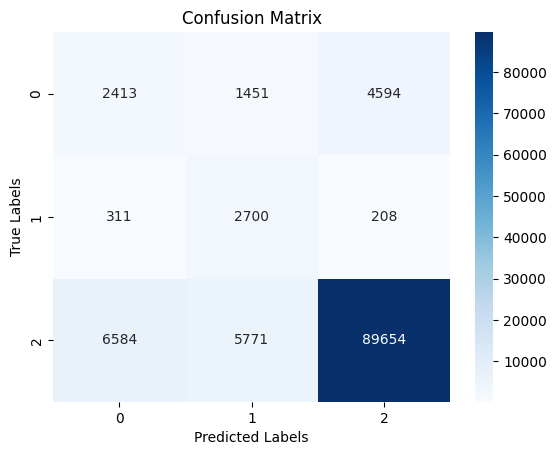

In [ ]:
#plot confusion matrix
conf_mat = confusion_matrix(y_test, predicted_classes)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()